In [1]:
from SimpleITK import GetImageFromArray
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
#from radiomics import generalinfo, getFeatureClasses, getImageTypes, getParameterValidationFiles, imageoperations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydicom import dcmread
import os
import nrrd
import SimpleITK as sitk
from radiomics import getTestCase
from radiomics import featureextractor
import six

###  First we will load 2 brain datasets with segmentations of brain tumors. The radiomics package will be used to extract a set of features, and the "signatures" will be compared.

In [2]:
# Here we use SimpleITK to load two brain images and the corresponding segmentations as label maps.
import os
import SimpleITK as sitk

from radiomics import getTestCase

imagepath_1, labelpath_1 = getTestCase('brain1')
imagepath_2, labelpath_2 = getTestCase('brain2')

image_1 = sitk.ReadImage(imagepath_1)
label_1 = sitk.ReadImage(labelpath_1)
image_2 = sitk.ReadImage(imagepath_2)
label_2 = sitk.ReadImage(labelpath_2)

In [3]:
# Convert into 2D image
img_10=sitk.GetArrayFromImage(image_1)[12,:,:]
lbl_10=sitk.GetArrayFromImage(label_1)[12,:,:]
img_20=sitk.GetArrayFromImage(image_2)[12,:,:]
lbl_20=sitk.GetArrayFromImage(label_2)[12,:,:]

# Show the images

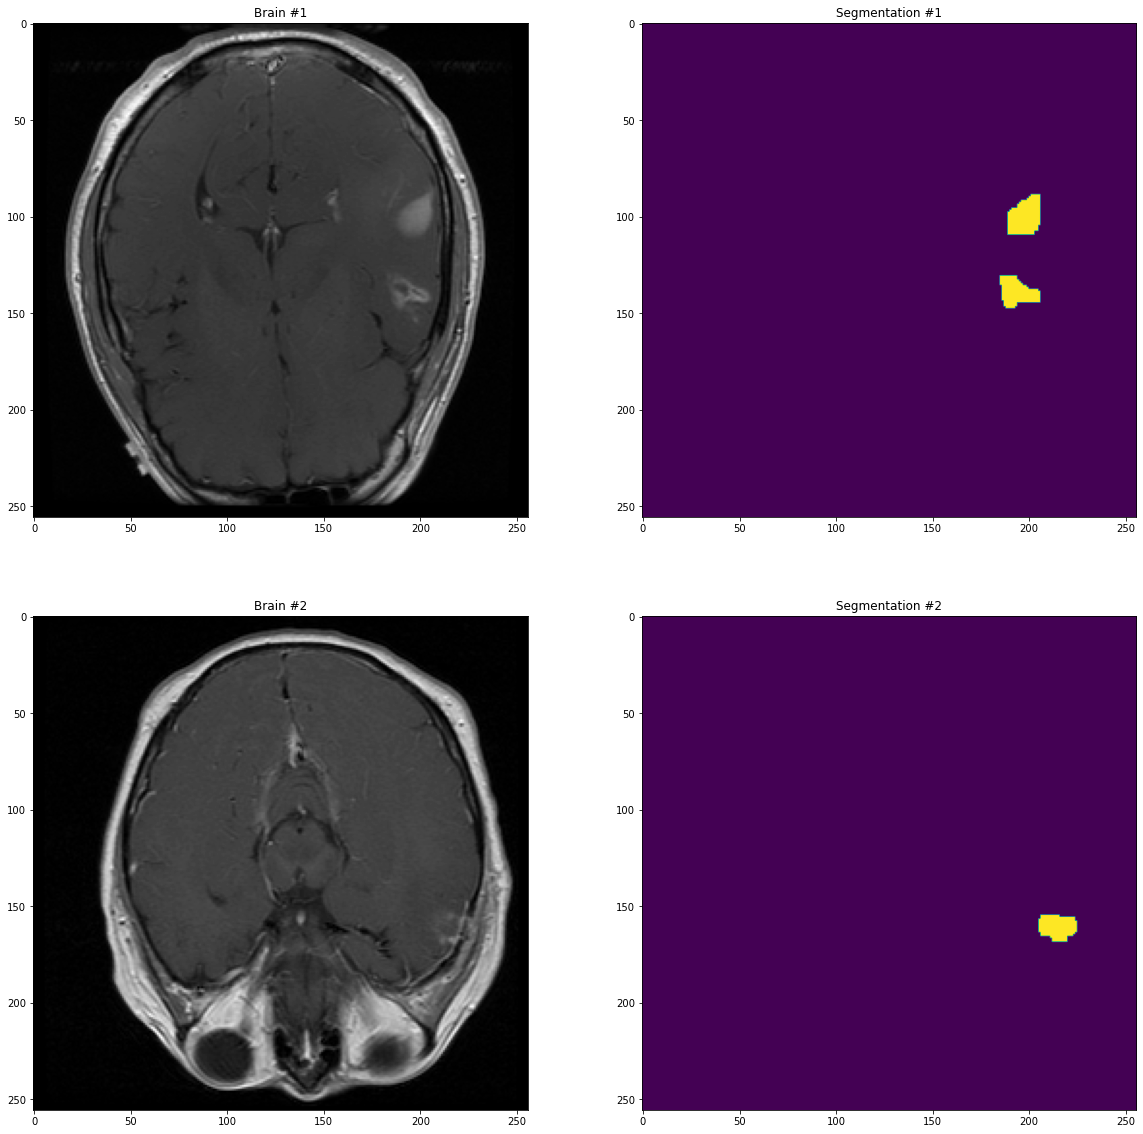

In [4]:
# Using matplotlib.pyplot (referenced as plt), display the images in grayscale and labels in color.
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[12,:,:], cmap="gray")
plt.title("Brain #1")
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[12,:,:])        
plt.title("Segmentation #1")

# Second image
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(image_2)[8,:,:], cmap="gray")        
plt.title("Brain #2")

plt.subplot(2,2,4)
plt.imshow(sitk.GetArrayFromImage(label_2)[8,:,:])        
plt.title("Segmentation #2")

plt.show()

## Extract the features

In [5]:
## Using the radiomics package, first construct an extractor. Then generate features for the two images
#result_1 = extractor.execute(image_1, label_1)
#result_2 = extractor.execute(image_2, label_2)
texture_extractor = RadiomicsFeatureExtractor()
results_1 = texture_extractor.execute(GetImageFromArray(img_10), GetImageFromArray((lbl_10>0).astype(np.uint8)))
results_2 = texture_extractor.execute(GetImageFromArray(img_20), GetImageFromArray((img_20>0).astype(np.uint8)))

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [6]:
len(results_1)

115

In [7]:
#df1=pd.DataFrame([results_1])
#df2=pd.DataFrame([results_2])
# Alternative: use hardcoded settings (separate for settings, input image types and enabled features)
settings = {}
settings['binWidth'] = 25
settings['resampledPixelSpacing'] = None
# settings['resampledPixelSpacing'] = [3, 3, 3]  # This is an example for defining resampling (voxels with size 3x3x3mm)
settings['interpolator'] = 'sitkBSpline'
settings['verbose'] = True

extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
# Load up the segmentations, 1 to 10 and extract the features
params = os.path.join(os.getcwd(), 'examples', 'exampleSettings', 'Params.yaml')

extractor = featureextractor.RadiomicsFeatureExtractor(params)
# hang on to all our features
features = {}

for case_id in range(1,11):
    path = 'example_data/tumorbase/AutomatedSegmentation/case{}/'.format(case_id)
    #image = np.load(r"C:\Users\lalit thakur\Downloads\Radiomics_FE\Radiomics\Prostate3T-01-0001_12.npy")
    #mask = np.load(r"C:\Users\lalit thakur\Downloads\Radiomics_FE\Radiomics\Prostate3T-01-0001_12_seg.npy")
    imageName, maskName = radiomics.getTestCase('brain1')
    # Tumor is in label value 6
    #features[case_id] = texture_extractor.execute(GetImageFromArray(image), GetImageFromArray((mask>0).astype(np.uint8)))
    features[case_id]= extractor.execute(imageName, maskName)

# A list of the valid features, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features[1] )))

In [8]:
samples = np.zeros((10,len(feature_names)))
for case_id in range(1,11):
    a = np.array([])
    for feature_name in feature_names:
        a = np.append(a, features[case_id][feature_name])
    samples[case_id-1,:] = a
    
# May have NaNs
samples = np.nan_to_num(samples)

In [9]:
# Make an array of the values
feature_1 = np.array([])
feature_2 = np.array([])

for key, value in six.iteritems(results_1):
    if key.startswith("original_"):
        feature_1 = np.append ( feature_1, results_1[key])
        feature_2 = np.append ( feature_2, results_2[key])

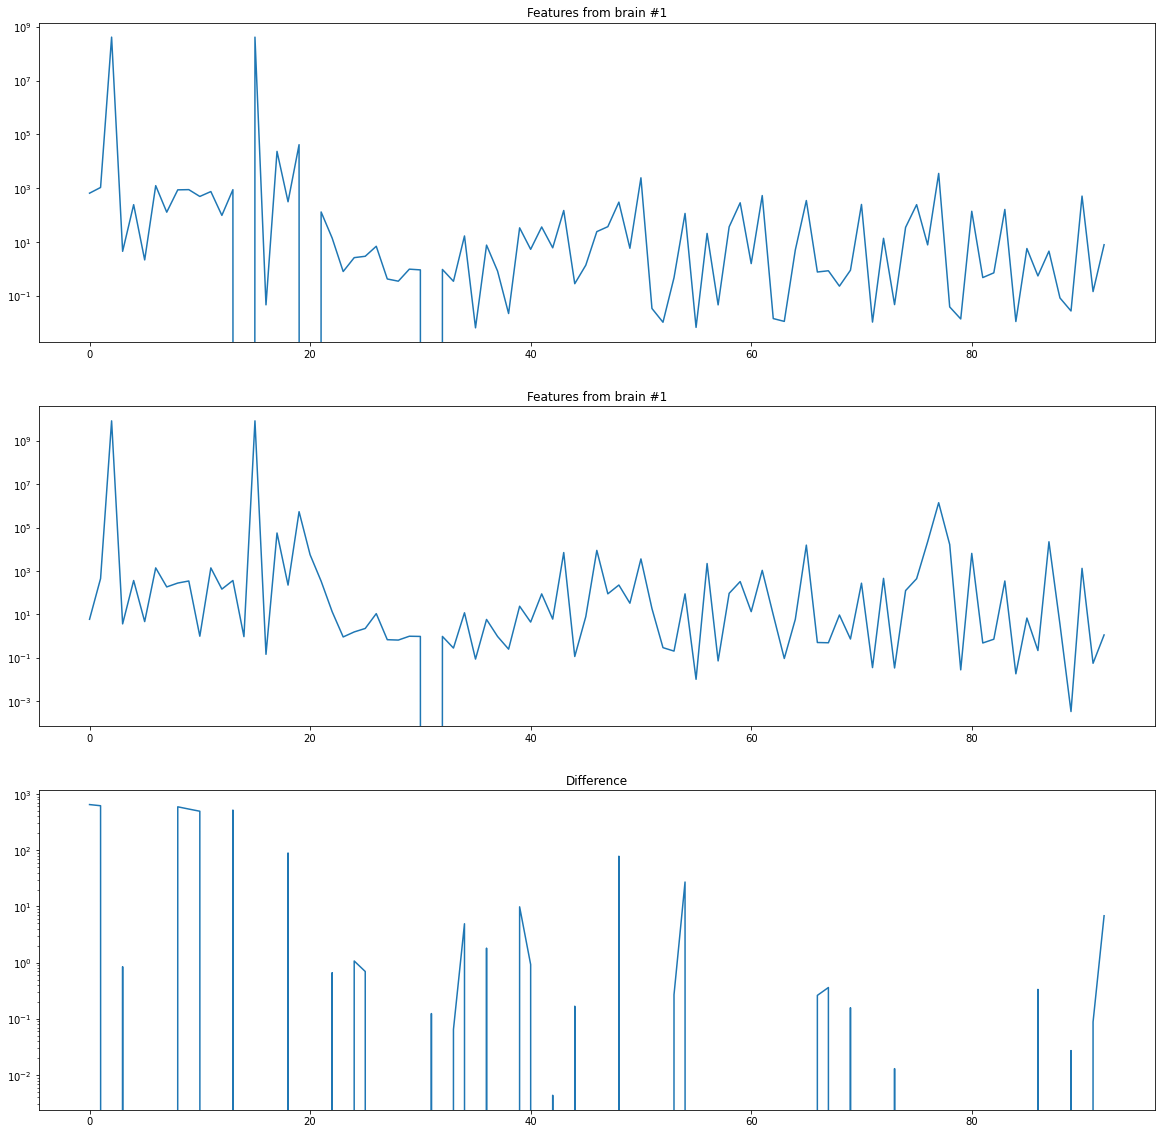

In [10]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.plot(feature_1)
plt.yscale('log')
plt.title ( "Features from brain #1")
        
plt.subplot(3,1,2)
plt.plot(feature_2)
plt.yscale('log')
plt.title ( "Features from brain #1")

plt.subplot(3,1,3)
plt.plot(feature_1 - feature_2)
plt.yscale('log')
plt.title ( "Difference")
plt.show()

# Let's do for whole Data

In [11]:
df=pd.read_csv("train.csv")
df.head()

,Scan_no,nrrd_path
0,1,Prostate3T-01-0001.nrrd
1,2,Prostate3T-01-0002.nrrd
2,3,Prostate3T-01-0003.nrrd
3,4,Prostate3T-01-0004.nrrd
4,5,Prostate3T-01-0005.nrrd


In [12]:
import numpy as np
from os import listdir

directory_path = '.'
file_types = ['npy', 'npz']

np_vars = {dir_content: np.load(dir_content)
           for dir_content in listdir(directory_path)
           if dir_content.split('.')[-1] in file_types}

In [13]:
import glob
numpy_vars = {}
for np_name in glob.glob('*.np[yz]'):
    numpy_vars[np_name] = np.load(np_name)

In [14]:
numpy_vars

{}

In [15]:
#Making pandas display all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [16]:
# perform on a sample nrrd file
#img = sitk.ReadImage(r"C:\Users\lalit thakur\Downloads\pyradiomics\train\Prostate3T-01-0002.nrrd")
data,header=nrrd.read(r"C:\Users\lalit thakur\Downloads\pyradiomics\train2\Prostate3T-01-0003.nrrd")
data.shape

(320, 320, 24)

In [17]:
#img2=sitk.GetArrayFromImage(img)[12,:,:]
#img2.shape
data1=data[:,:,12]
data1.shape

(320, 320)

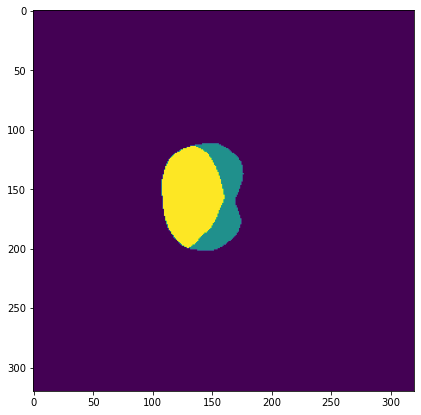

In [18]:
#plt.imshow(sitk.GetArrayFromImage(img)[12,:,:])
plt.figure(figsize=(7,7))
plt.imshow(data1)

In [19]:
# For first image
img = np.load(r"C:\Users\lalit thakur\Downloads\train\Prostate3T-01-0001_9.npy")
msk = np.load(r"C:\Users\lalit thakur\Downloads\train\Prostate3T-01-0001_9_mask.npy")
# for second image
img1 = np.load(r"C:\Users\lalit thakur\Downloads\train\Prostate3T-01-0001_6.npy")
msk1 = np.load(r"C:\Users\lalit thakur\Downloads\train\Prostate3T-01-0001_6_mask.npy")

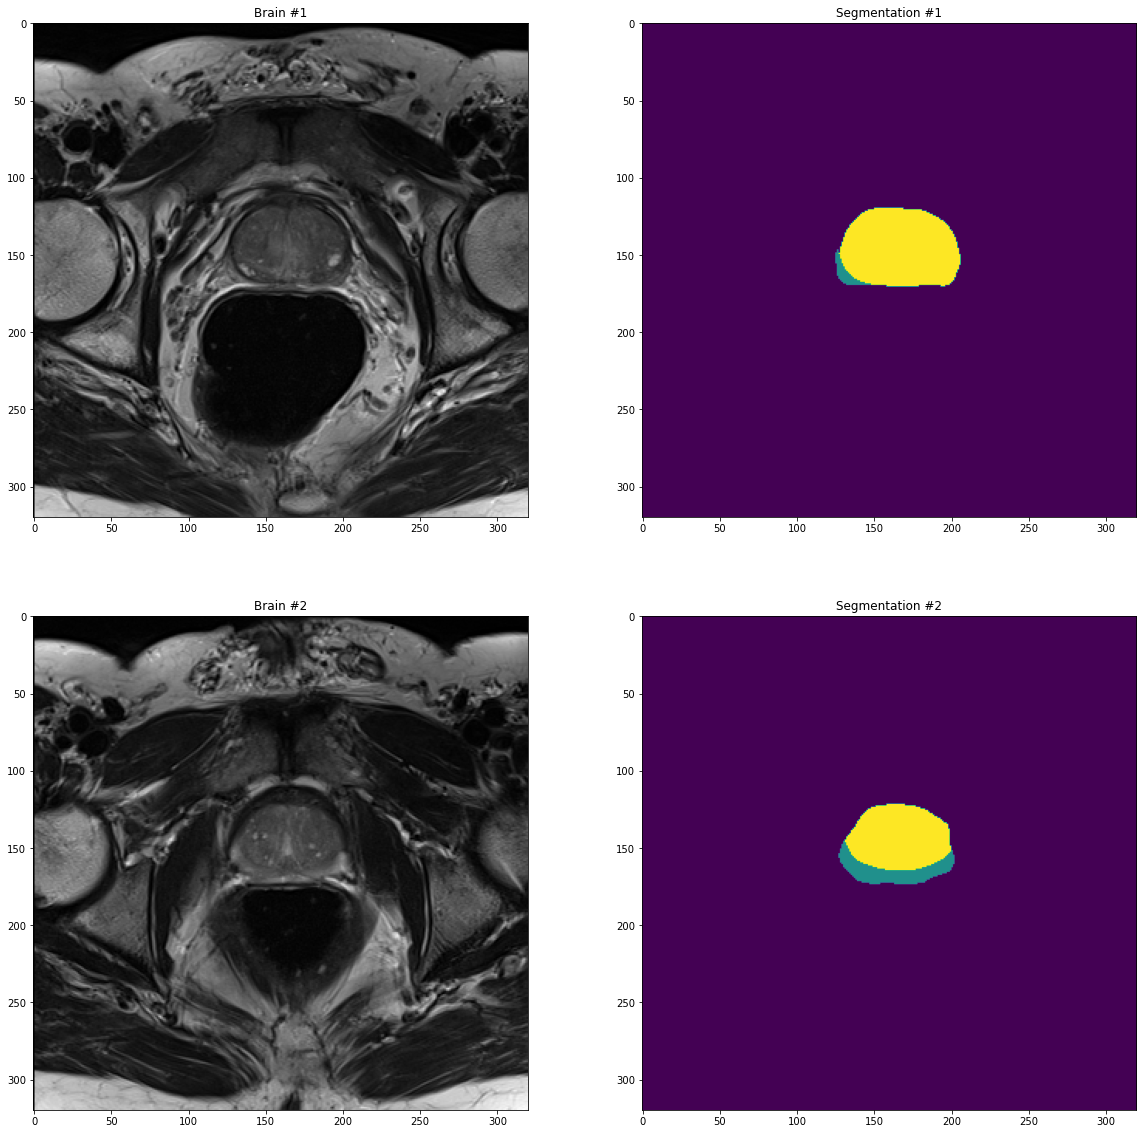

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow((img), cmap="gray")
plt.title("Brain #1")
plt.subplot(2,2,2)
plt.imshow((msk))        
plt.title("Segmentation #1")


# Second image
plt.subplot(2,2,3)
plt.imshow((img1), cmap="gray")
plt.title("Brain #2")
plt.subplot(2,2,4)
plt.imshow((msk1))        
plt.title("Segmentation #2")
plt.show()

In [21]:
#df=pd.DataFrame([results]).T
#df
path = os.path.join("C:\\Users\lalit thakur\Downloads\pyradiomics", "train2")
print(path)

C:\Users\lalit thakur\Downloads\pyradiomics\train2


In [22]:
#path1="C:\Users\lalit thakur\Downloads\pyradiomics"
def read_scan(in_filename, folder='train2'):
    full_scan_path = os.path.join("C:\\Users\lalit thakur\Downloads\pyradiomics",folder, in_filename)
    # load the image using hdf5
    data,header=nrrd.read(full_scan_path,"r")
    
    return data[:,:,12]
    
    #with sitk.ReadImage(full_scan_path,"r") as h:
        # [::2, ::4, ::4, 0] downsampling makes it go much faster
        #return h["image"]
#[:][:, :, :, 0] # we read the data from the file

In [23]:
sample_scan = df.iloc[0] # just take the first row
print(sample_scan)
# turn the h5_path into the full path
image_data =read_scan(sample_scan['nrrd_path'])
#img_n2=sitk.GetArrayFromImage(image_data)[:,:,12]
print('Image Shape:', image_data.shape)

Scan_no                            1
nrrd_path    Prostate3T-01-0001.nrrd
Name: 0, dtype: object
Image Shape: (320, 320)


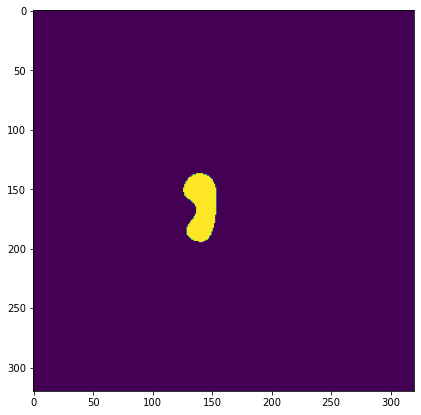

In [24]:
plt.figure(figsize=(7,7))
plt.imshow(image_data)

In [25]:
texture_extractor = RadiomicsFeatureExtractor()
results = texture_extractor.execute(GetImageFromArray(image_data), GetImageFromArray((image_data>0).astype(np.uint8)))

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [26]:
df1=pd.DataFrame([results]).T
df1

,0
diagnostics_Versions_PyRadiomics,0+unknown
diagnostics_Versions_Numpy,1.21.5
diagnostics_Versions_SimpleITK,2.1.1.2
diagnostics_Versions_PyWavelet,1.3.0
diagnostics_Versions_Python,3.9.12
diagnostics_Configuration_Settings,"{'minimumROIDimensions': 2, 'minimumROISize': ..."
diagnostics_Configuration_EnabledImageTypes,{'Original': {}}
diagnostics_Image-original_Hash,8650791847c1a61668cacd0f1fcc52eb421c5664
diagnostics_Image-original_Dimensionality,2D
diagnostics_Image-original_Spacing,"(1.0, 1.0)"


In [27]:
def calc_radiomics(in_image_data):
    return texture_extractor.execute(GetImageFromArray(in_image_data), GetImageFromArray((in_image_data>0).astype(np.uint8)))

In [28]:
df['radiomics'] = df['nrrd_path'].map(lambda c_filename: calc_radiomics(read_scan(c_filename)))
new_train_df = pd.DataFrame([dict(**c_row.pop('radiomics'), **c_row) for _, c_row in df.iterrows()])
first_cols = new_train_df.columns[:-1].tolist()
new_train_df = new_train_df[first_cols + [c_col for c_col in new_train_df.columns 
                                if c_col not in first_cols]]
# export the whole table
new_train_df.to_csv('all_radiomics_table.csv', index=False)
new_train_df.sample(3)
print(new_train_df.shape, 'data prepared')
new_train_df.sample(25)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

(60, 117) data prepared


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Scan_no,nrrd_path
49,0+unknown,1.21.5,2.1.1.2,1.3.0,3.9.12,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},5eef95b84a7e61b

In [29]:
new_train_df.shape

(60, 117)

# Focusing on Interesting Radiomics

In [30]:
value_feature_names = [c_col for c_col in new_train_df.columns if (c_col.startswith('original') and '_shape_' not in c_col)]
print(np.random.choice(value_feature_names, 3), 'of', len(value_feature_names))

['original_firstorder_Entropy' 'original_gldm_GrayLevelVariance'
 'original_glrlm_ShortRunLowGrayLevelEmphasis'] of 93


In [31]:
# make a cleaner vefirst_colson
clean_df = new_train_df[first_cols + value_feature_names].copy()
clean_df.columns = first_cols + [
    ' '.join(c_col.split('original_')[-1].split('_')) 
    for c_col in value_feature_names
]
clean_col_names = clean_df.columns[len(first_cols):]
# fix some of the artifacts from the radiomics tool
obj_cols = clean_df[clean_col_names].select_dtypes(['object']).columns.tolist()
for c_col in obj_cols:
    clean_df[c_col] = clean_df[c_col].map(lambda x: float(x))
clean_df.to_csv('clean_radiomics_table.csv', index=False)
clean_df.sample(3)

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Scan_no,firstorder 10Percentile,firstorder 90Percentile,firstorder Energy,firstorder Entropy,firstorder InterquartileRange,firstorder Kurtosis,

In [32]:
df3=pd.read_csv("clean_radiomics_table.csv")

In [33]:
df3.shape

(60, 209)

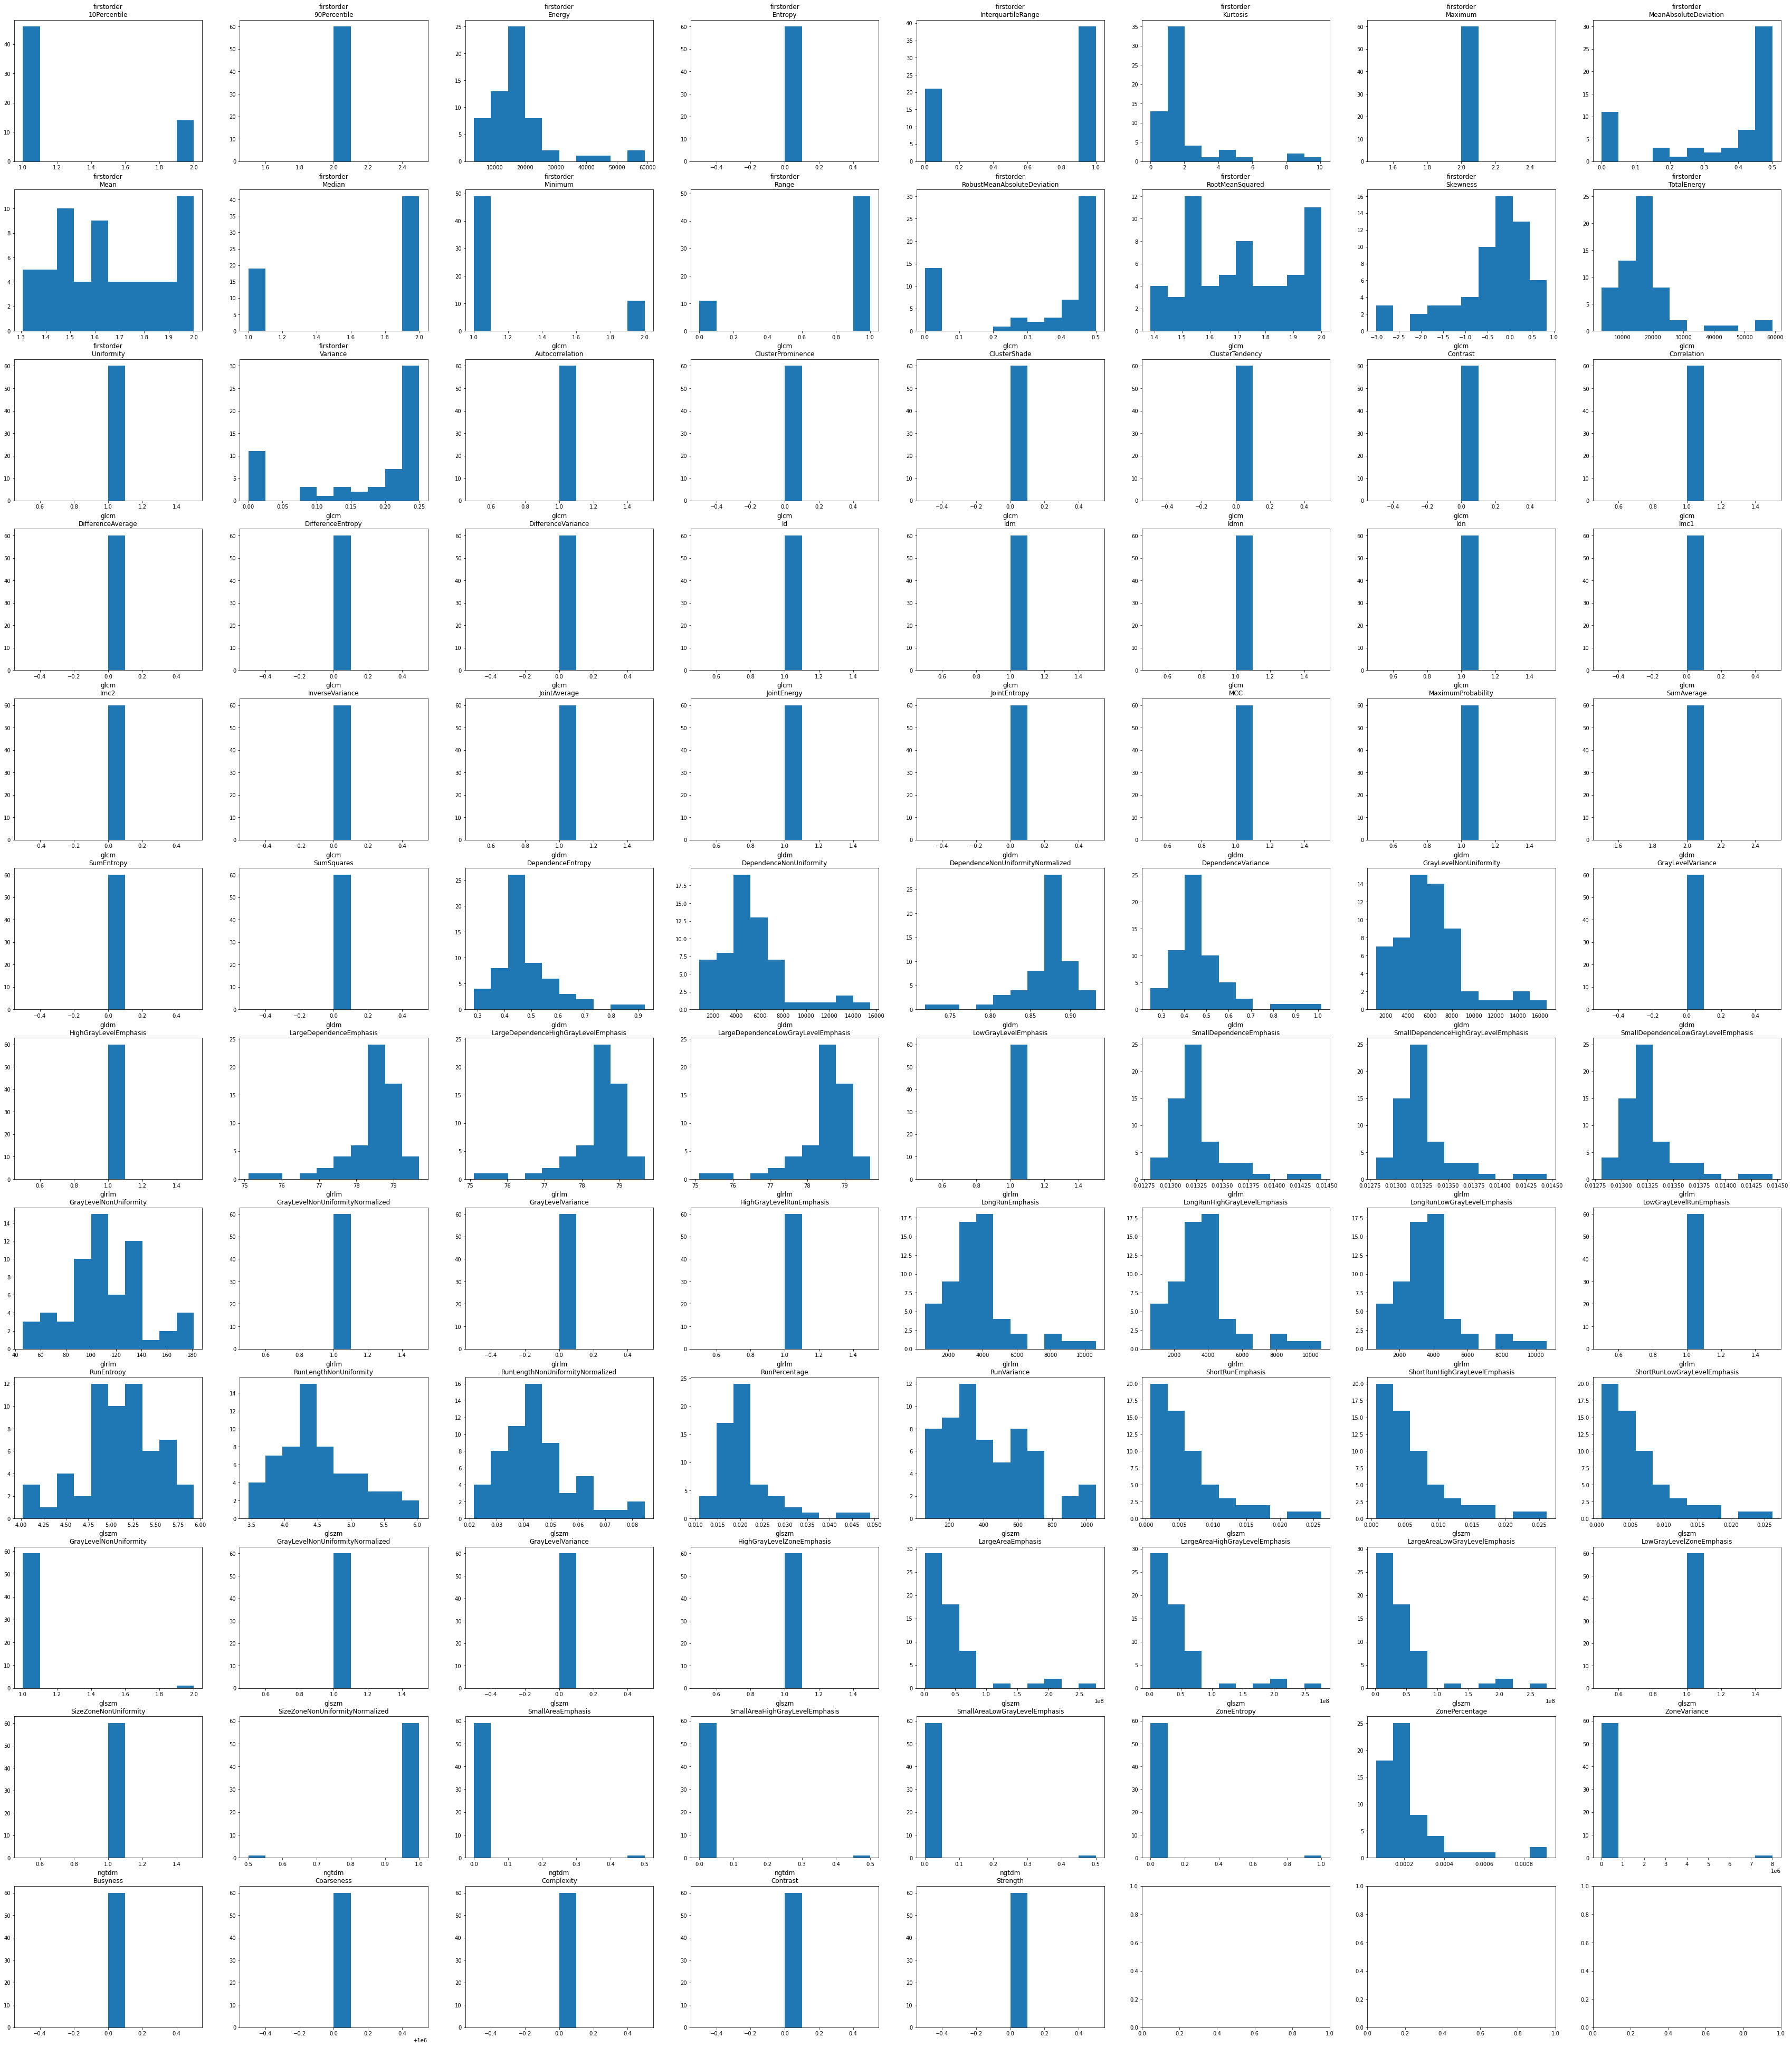

In [34]:
fig, m_axs = plt.subplots(12, 8, figsize=(60, 70))
for c_ax, c_var in zip(m_axs.flatten(), clean_col_names):
    c_ax.hist(clean_df[c_var].values, bins=10)
    c_ax.set_title('\n'.join(c_var.split(' ')))
fig.savefig('all_metrics.png')

## Exploring the effects of filtering on Radiomics features

In [35]:
# from it's default location in \pyradiomics\examples\Notebooks
repositoryRoot = os.path.abspath(os.path.join(os.getcwd(), ".."))

imagepath, labelpath = getTestCase('brain1', repositoryRoot)

image = sitk.ReadImage(imagepath)
label = sitk.ReadImage(labelpath)

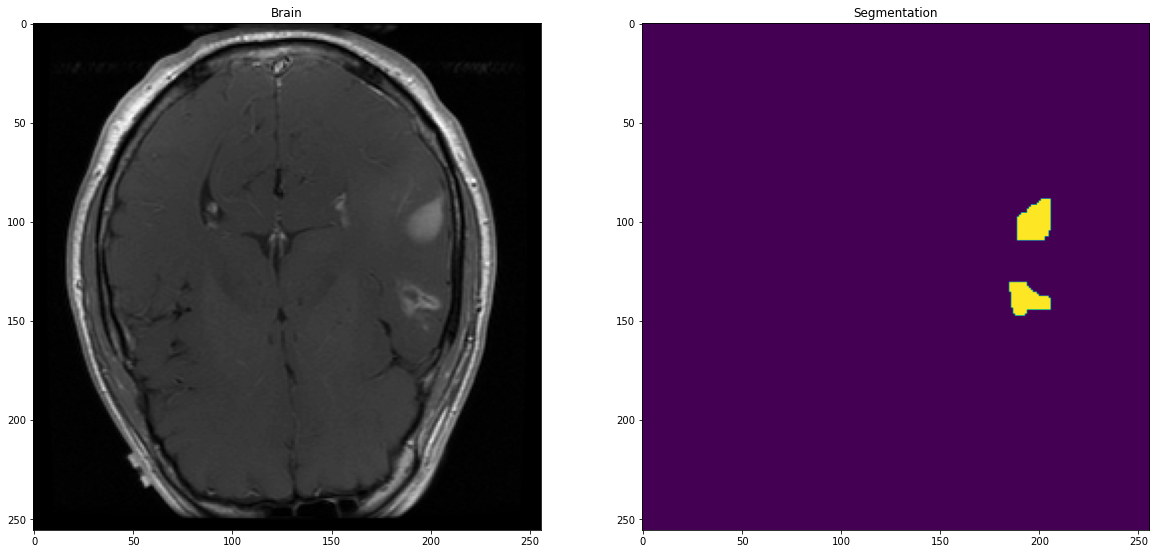

In [36]:
# Show the image using matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap="gray")
plt.title("Brain")
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(label)[12,:,:])        
plt.title("Segmentation")

plt.show()


In [37]:
# Extract feature from this particular images
# Instantiate the extractor
params = os.path.join(os.getcwd(), 'examples', 'exampleSettings', 'Params.yaml')

extractor = featureextractor.RadiomicsFeatureExtractor(params)
extractor.enableFeatureClassByName('shape', enabled=False)

In [38]:
# Construct a set of SimpleITK filter objects
filters = {
    "AdditiveGaussianNoise" : sitk.AdditiveGaussianNoiseImageFilter(),
    "Bilateral" : sitk.BilateralImageFilter(),
    "BinomialBlur" : sitk.BinomialBlurImageFilter(),
    "BoxMean" : sitk.BoxMeanImageFilter(),
    "BoxSigmaImageFilter" : sitk.BoxSigmaImageFilter(),
    "CurvatureFlow" : sitk.CurvatureFlowImageFilter(),
    "DiscreteGaussian" : sitk.DiscreteGaussianImageFilter(),
    "LaplacianSharpening" : sitk.LaplacianSharpeningImageFilter(),
    "Mean" : sitk.MeanImageFilter(),
    "Median" : sitk.MedianImageFilter(),
    "Normalize" : sitk.NormalizeImageFilter(),
    "RecursiveGaussian" : sitk.RecursiveGaussianImageFilter(),
    "ShotNoise" : sitk.ShotNoiseImageFilter(),
    "SmoothingRecursiveGaussian" : sitk.SmoothingRecursiveGaussianImageFilter(),
    "SpeckleNoise" : sitk.SpeckleNoiseImageFilter(),
}

# Filter
for key, value in six.iteritems(filters):
    print ( "filtering with " + key )
    filtered_image = value.Execute(image)
    results[key] = extractor.execute(filtered_image, label)

filtering with AdditiveGaussianNoise
filtering with Bilateral
filtering with BinomialBlur
filtering with BoxMean
filtering with BoxSigmaImageFilter
filtering with CurvatureFlow
filtering with DiscreteGaussian
filtering with LaplacianSharpening
filtering with Mean
filtering with Median
filtering with Normalize
filtering with RecursiveGaussian
filtering with ShotNoise
filtering with SmoothingRecursiveGaussian
filtering with SpeckleNoise


# Determine which features had the highest variance.



In [39]:
# Keep an index of filters and features
filter_index = list(sorted(filters.keys()))
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), results[filter_index[0]] )))

### Look at the features with highest and lowest coefficient of variation

In [40]:
# Pull in scipy to help find cv
import scipy.stats

features = {}
cv = {}

for key in feature_names:
    a = np.array([])
    for f in filter_index:
        a = np.append(a, results[f][key])
    features[key] = a
    cv[key] = scipy.stats.variation(a)
    
# a sorted view of cv
cv_sorted = sorted(cv, key=cv.get, reverse=True)

# Print the top 10
print ("\n")
print ("Top 10 features with largest coefficient of variation")
for i in range(0,10):
    print ("Feature: {:<50} CV: {}".format ( cv_sorted[i], cv[cv_sorted[i]]))
    
print ("\n")
print ("Bottom 10 features with _smallest_ coefficient of variation")
for i in range(-11,-1):
    print ("Feature: {:<50} CV: {}".format ( cv_sorted[i], cv[cv_sorted[i]]))



Top 10 features with largest coefficient of variation
Feature: original_glszm_LargeAreaLowGrayLevelEmphasis       CV: 3.7415428895060217
Feature: original_glszm_LargeAreaEmphasis                   CV: 3.7382202529879685
Feature: original_glcm_ClusterShade                         CV: 3.737911057513535
Feature: original_glszm_ZoneVariance                        CV: 3.732272283283503
Feature: original_glcm_ClusterProminence                    CV: 3.730316529592371
Feature: original_glrlm_LongRunLowGrayLevelEmphasis         CV: 3.7202232557668884
Feature: original_gldm_LargeDependenceLowGrayLevelEmphasis  CV: 3.660860437897661
Feature: original_glszm_LargeAreaHighGrayLevelEmphasis      CV: 3.5272165266158604
Feature: original_glcm_DifferenceVariance                   CV: 3.3757814969820035
Feature: original_glcm_JointEnergy                          CV: 3.3734844932960457


Bottom 10 features with _smallest_ coefficient of variation
Feature: original_glcm_SumEntropy                       